<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_05_auto_ml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v1'

In [2]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1015 (delta 46), reused 13 (delta 6), pack-reused 936
Receiving objects: 100% (1015/1015), 70.94 MiB | 36.85 MiB/s, done.
Resolving deltas: 100% (594/594), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.ensemble import RandomForestClassifier

# from scikitplot.plotters import plot_precision_recall_curve

from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

import xgboost as xgb

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labelled_scatter

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.pkl"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 4630M
-rw------- 1 root root 1555M Jan  5 23:01 feature_matrix_d2.pkl
-rw------- 1 root root 1528M Jan  7 00:07 feature_matrix_d2_v1_origin.pkl
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
total 1M
-rw-r--r-- 1 root root 1M Jan 10 13:57 4D.zip


In [0]:
data = pd.read_pickle(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 213 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(2)
memory usage: 1.5 GB


## Exploratory Data Analysis

### View data

In [0]:
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [12]:
print(feature_matrix.columns)

Index(['time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
       'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
       'MIN(Results.DrawNo)',
       ...
       'PERCENTILE(MAX(Results.DrawNo))',
       'PERCENTILE(TREND(Results.LuckyNo, DrawDate))',
       'PERCENTILE(LAST(Results.TotalStrike))',
       'PERCENTILE(LAST(Results.LuckyNo))',
       'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
       'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize'],
      dtype='object', length=210)


In [13]:
feature_matrix[feature_matrix['Label'] == 1 ].tail(4)

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
950205,2019-12-01,0.0,0.0,127054.467100,9957,1,479318,9957,1,140498,9957,1,311519.333333,0.0,0.0,-0.012912,9957,1,100862,479318,78019200.0,9,89613,9,2803674,0.0,0.0,0.032599,1,16,9,0,669254340.0,63521.940426,2.338165e+08,0.274341,1.452695e+08,29218.946689,0.0,0.0,...,460830.857063,0.0,1.0,5004.820912,1.0,266657.801609,27,6,0,0.50005,0.50005,0.8357,0.916225,0.4834,0.32300,0.32300,0.9958,0.50005,0.89905,0.50005,0.50005,0.50005,0.485937,0.56675,0.50005,0.9958,0.50005,0.3915,0.9958,0.56380,0.56675,0.50005,0.50005,0.9958,0.50005,0.8226,1.0,1,1,1
950206,2019-12-01,0.0,0.0,87070.473740,9964,1,343510,9964,1,100096,9964,1,220612.090909,0.0,0.0,-0.225108,9964,1,69635,343510,46483200.0,11,109604,11,2426733,0.0,0.0,0.031344,1,17,2,0,750643140.0,43536.467551,1.666614e+08,0.188005,9.967259e+07,20027.865006,0.0,0.0,...,460467.145418,0.0,1.0,4999.691371,1.0,261837.337829,10,11,0,0.50005,0.50005,0.9263,0.035232,0.3364,0.56205,0.56205,0.9965,0.50005,0.74750,0.50005,0.50005,0.50005,0.329597,0.02420,0.50005,0.9965,0.50005,0.0351,0.9965,0.04675,0.02420,0.50005,0.50005,0.9965,0.50005,0.1111,1.0,1,1,1
950207,2019-12-01,0.0,0.0,111384.241449,9989,1,434715,9989,1,41692,9989,1,219502.777778,0.0,0.0,0.437460,9989,1,90599,434715,93031200.0,9,89901,9,1975525,0.0,0.0,0.031669,1,27,5,0,868233540.0,55681.529797,2.109426e+08,0.240496,1.274390e+08,25613.543923,0.0,0.0,...,457987.417431,0.0,1.0,5110.967890,1.0,253949.170276,27,12,0,0.50005,0.50005,0.8375,0.122710,0.1801,0.32300,0.32300,0.9990,0.50005,0.02170,0.50005,0.50005,0.50005,0.792313,0.20020,0.50005,0.9990,0.50005,0.1763,0.9990,0.74565,0.20020,0.50005,0.5000

In [14]:
origin_data[origin_data.LuckyNo == 9957]

,DrawNo,DrawDate,PrizeType,LuckyNo
22933,140498,1998-09-16,3rdPrizeNo,9957
25390,151099,1999-05-11,SpecialNo8,9957
44467,234104,2004-06-05,ConsolationNo5,9957
53282,272406,2006-09-02,SpecialNo10,9957
53956,275306,2006-11-08,SpecialNo8,9957
79659,387113,2013-04-24,ConsolationNo7,9957
81901,396813,2013-11-10,SpecialNo8,9957
98026,467017,2017-10-18,1stPrizeNo,9957
100862,479318,2018-06-27,ConsolationNo4,9957
106753,504919,2019-12-22,ConsolationNo7,9957


In [15]:
feature_matrix.describe().round(2)

,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.PERCENTILE(TotalStrike)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
count,958948.0,958948.0,958948.00,959893.00,959893.0,959893.00,959893.00,959893.0,959893.00,959893.00,959893.0,959893.00,952257.0,952257.0,952257.00,959893.00,959893.0,959893.00,959893.00,9.589480e+05,959893.00,959893.00,959893.00,959893.00,952257.0,952257.0,952257.00,959893.0,959893.00,959893.00,959893.0,9.598930e+05,958948.00,9.589480e+05,958948.00,9.589480e+05,958948.00,958948.0,958948.0,958948.0,...,959893.00,952257.0,959893.0,959893.00,959893.0,959893.00,959893.0,959893.00,959893.0,959893.0,958948.0,959893.00,952257.00,959893.00,959893.00,959893.00,959893.00,959893.0,959893.00,958948.0,952257.0,952257.0,952257.00,959893.00,952257.0,959893.00,959893.0,958948.00,959893.00,958948.00,959893.00,952257.0,959893.0,959893.00,959893.0,959893.00,959893.00,959893.00,959893.0,959893.0
mean,0.0,0.0,111342.20,4999.18,1.0,390906.91,4999.18,1.0,83952.25,4999.18,1.0,237399.51,0.0,0.0,-0.00,4999.18,1.0,80532.69,390906.91,8.234844e+07,9.05,45042.83,9.05,2168380.75,0.0,0.0,0.03,1.0,15.66,6.67,0.0,6.586662e+08,55666.09,2.109083e+08,0.28,1.274557e+08,25606.24,0.0,0.0,0.0,...,390647.83,0.0,1.0,4997.24,1.0,223470.76,15.8,6.51,0.0,0.5,0.5,0.50,0.50,0.50,0.50,0.50,0.50,0.5,0.50,0.5,0.5,0.5,0.50,0.50,0.5,0.50,0.5,0.50,0.50,0.50,0.50,0.5,0.5,0.50,0.5,0.50,0.03,0.03,1.0,1.0
std,0.0,0.0,25772.65,2886.68,0.0,59335.80,2886.68,0.0,42863.89,2886.68,0.0,45425.90,0.0,0.0,0.66,2886.68,0.0,13646.27,59335.80,3.895532e+07,3.16,31606.21,3.16,904878.09,0.0,0.0,0.00,0.0,8.81,3.37,0.0,1.119074e+08,12886.48,4.813546e+07,0.06,2.949965e+07,5927.49,0.0,0.0,0.0,...,41330.44,0.0,0.0,136.49,0.0

In [16]:
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


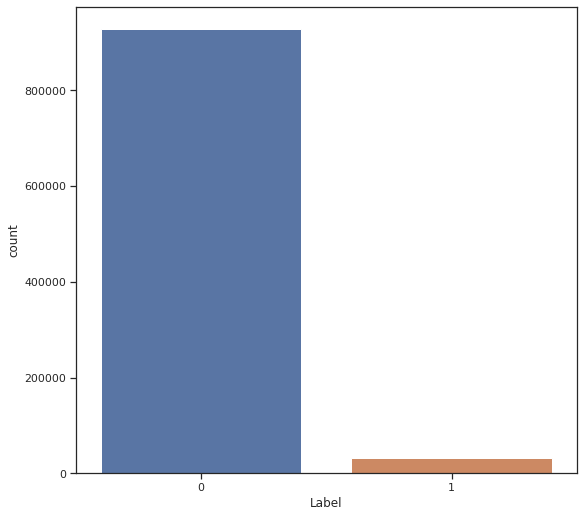

In [17]:
plt.figure(figsize=(8, 8))
sns.countplot('Label', data=feature_matrix)

In [18]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.CUM_SUM(DrawNo))                       7636
SKEW(Results.TotalStrike)                           7636
TREND(Results.PERCENTILE(TotalStrike), DrawDate)    7636
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          7636
TREND(Results.CUM_SUM(DrawNo), DrawDate)            7636
                                                    ... 
CUM_SUM(MIN(Results.TotalStrike))                      0
NUM_UNIQUE(Results.MONTH(DrawDate))                    0
NUM_UNIQUE(Results.HOUR(DrawDate))                     0
NUM_UNIQUE(Results.DAY(DrawDate))                      0
time                                                   0
Length: 210, dtype: int64

In [19]:
feature_matrix.isnull().sum().sort_values(ascending=False)

SKEW(Results.CUM_SUM(DrawNo))                       7636
SKEW(Results.TotalStrike)                           7636
TREND(Results.PERCENTILE(TotalStrike), DrawDate)    7636
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          7636
TREND(Results.CUM_SUM(DrawNo), DrawDate)            7636
                                                    ... 
CUM_SUM(MIN(Results.TotalStrike))                      0
NUM_UNIQUE(Results.MONTH(DrawDate))                    0
NUM_UNIQUE(Results.HOUR(DrawDate))                     0
NUM_UNIQUE(Results.DAY(DrawDate))                      0
time                                                   0
Length: 210, dtype: int64

In [20]:
len(feature_matrix[feature_matrix.isnull().any(axis=1)].time.unique())

96

In [21]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
116,2012-01-01,NaN,NaN,NaN,3294,1,104596,3294,1,104596,3294,1,104596.0,NaN,NaN,NaN,3294,1,14682,104596,NaN,1,3294,1,104596,NaN,NaN,NaN,1,1,6,0,491788740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,320021.630851,NaN,1.0,5001.828161,1.0,192504.336473,1,6,0,0.50005,NaN,0.053427,NaN,0.001001,0.001901,0.001901,0.329665,0.50005,0.773887,NaN,NaN,NaN,NaN,0.002201,NaN,0.329665,0.50005,NaN,0.329665,NaN,0.002201,NaN,0.50005,0.329665,0.50005,0.007804,1.0,1,1,1
126,2012-01-01,0.0,0.0,90302.485705,3455,1,327109,3455,1,199402,3455,1,263255.5,NaN,NaN,NaN,3455,1,65850,327109,240278400.0,2,6910,2,526511,NaN,NaN,NaN,1,28,4,0,305423940.0,45155.660222,1.699025e+08,0.279732,1.035840e+08,20767.726163,0.0,0.0,...,320268.030020,NaN,1.0,5003.717418,1.0,200090.691887,8,12,0,0.50005,0.50005,0.108754,NaN,0.037919,0.013057,0.013057,0.345773,0.50005,0.976538,0.50005,NaN,NaN,NaN,0.429465,NaN,0.345773,0.50005,0.457421,0.345773,0.987447,0.429465,NaN,0.50005,0.345773,0.50005,0.950675,1.0,1,1,1
128,2012-01-01,0.0,0.0,7990.306627,3479,1,362211,3479,1,350911,3479,1,356561.0,NaN,NaN,NaN,3479,1,73941,362211,20563200.0,2,6958,2,713122,NaN,NaN,NaN,1,10,4,0,22982340.0,4020.215271,1.454038e+07,0.024753,9.217371e+06,1849.084233,0.0,0.0,...,320438.809529,NaN,1.0,4997.881393,1.0,202004.621243,4,12,0,0.50005,0.50005,0.109555,NaN,0.087744,0.013057,0.013057,0.348174,0.50005,0.999650,0.50005,NaN,NaN,NaN,0.969335,NaN,0.348174,0.50005,0.001808,0.348174,0.002209,0.969335,NaN,0.50005,0.348174,0.50005,0.999900,1.0,1,1,1
199,2012-01-01,0.0,0.0,126014.206582,5870,1,239204,5870,1,60993,5870,1,150098.5,NaN,NaN,NaN,5870,1,45633,239204,350352000.0,2,1

### Data Cleansing

In [0]:
## Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [23]:
feature_matrix.isnull().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                    0
MAX(Results.CUM_MEAN(LuckyNo))                   0
SKEW(Results.CUM_MEAN(DrawNo))                   0
MEAN(Results.CUM_MEAN(LuckyNo))                  0
MEAN(Results.CUM_SUM(DrawNo))                    0
                                                ..
CUM_SUM(LAST(Results.DrawNo))                    0
CUM_SUM(SKEW(Results.DrawNo))                    0
CUM_SUM(TREND(Results.TotalStrike, DrawDate))    0
CUM_SUM(SKEW(Results.LuckyNo))                   0
time                                             0
Length: 210, dtype: int64

In [24]:
feature_matrix.isna().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                    0
MAX(Results.CUM_MEAN(LuckyNo))                   0
SKEW(Results.CUM_MEAN(DrawNo))                   0
MEAN(Results.CUM_MEAN(LuckyNo))                  0
MEAN(Results.CUM_SUM(DrawNo))                    0
                                                ..
CUM_SUM(LAST(Results.DrawNo))                    0
CUM_SUM(SKEW(Results.DrawNo))                    0
CUM_SUM(TREND(Results.TotalStrike, DrawDate))    0
CUM_SUM(SKEW(Results.LuckyNo))                   0
time                                             0
Length: 210, dtype: int64

In [25]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize


### Feature Selection

In [0]:
# Feature scaling first??


In [26]:
print(feature_matrix.shape)
feature_matrix.columns

(959893, 210)


Index(['time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
       'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
       'MIN(Results.DrawNo)',
       ...
       'PERCENTILE(MAX(Results.DrawNo))',
       'PERCENTILE(TREND(Results.LuckyNo, DrawDate))',
       'PERCENTILE(LAST(Results.TotalStrike))',
       'PERCENTILE(LAST(Results.LuckyNo))',
       'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
       'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize'],
      dtype='object', length=210)

In [27]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 207)
0 missing columns with threshold: 90.
46 zero variance columns.
108 collinear columns removed with threshold: 0.95.
Total columns removed:  154
Shape after feature selection: (959893, 53).


In [28]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 53),
 Index(['STD(Results.DrawNo)', 'MAX(Results.LuckyNo)', 'MAX(Results.DrawNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.LuckyNo)', 'SUM(Results.DrawNo)',
        'TREND(Results.DrawNo, DrawDate)', 'DAY(first_Results_time)',
        'MONTH(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))', 'STD(Results.CUM_SUM(DrawNo))',
        'STD(Results.CUM_MEAN(LuckyNo))', 'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))', 'MIN(Results.CUM_MEAN(LuckyNo))',
        'MODE(Results.DAY(DrawDate))', 'MODE(Results.MONTH(DrawDate))',
        'MEAN(Results.TIME_SINCE(DrawDate))',
        'MEAN(Results.PERCENTILE(DrawNo))', 'MEAN(Results.CUM_MEAN(LuckyNo))',
        'SKEW(Results.CUM_SUM(DrawNo))', 'SKEW(Results.CUM_MEAN(LuckyNo))',
        'LAST(Resul

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [30]:
# Check without feature selection
corrs = feature_matrix.corr().sort_values('Label')
corrs['Label'].tail(100)

TREND(Results.TIME_SINCE(DrawDate), DrawDate)    0.000523
PERCENTILE(SUM(Results.DrawNo))                  0.000610
CUM_SUM(SUM(Results.DrawNo))                     0.000678
TREND(Results.PERCENTILE(LuckyNo), DrawDate)     0.000687
MONTH(first_Results_time)                        0.000858
                                                   ...   
CUM_MEAN(LAST(Results.TotalStrike))                   NaN
CUM_MEAN(NUM_UNIQUE(Results.PrizeType))               NaN
HOUR(LAST(Results.DrawDate))                          NaN
MODE(Results.PrizeType)_Prize                         NaN
LAST(Results.PrizeType)_Prize                         NaN
Name: Label, Length: 100, dtype: float64

In [31]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')
corrs['Label'].tail(20)

TREND(Results.PERCENTILE(TotalStrike), DrawDate)   -0.000156
PERCENTILE(COUNT(Results))                         -0.000139
PERCENTILE(LAST(Results.DrawNo))                   -0.000094
MODE(Results.DAY(DrawDate))                         0.000471
PERCENTILE(SUM(Results.DrawNo))                     0.000610
TREND(Results.PERCENTILE(LuckyNo), DrawDate)        0.000687
MONTH(first_Results_time)                           0.000858
PERCENTILE(TREND(Results.DrawNo, DrawDate))         0.000912
LAST(Results.CUM_MEAN(LuckyNo))                     0.000988
MAX(Results.CUM_MEAN(LuckyNo))                      0.001007
MEAN(Results.PERCENTILE(DrawNo))                    0.001149
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          0.001493
TREND(Results.PERCENTILE(DrawNo), DrawDate)         0.001528
PERCENTILE(MIN(Results.TotalStrike))                0.001564
CUM_SUM(MIN(Results.TotalStrike))                   0.001572
MIN(Results.DrawNo)                                 0.001718
MAX(Results.PERCENTILE(T

### Balancing data

In [0]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, AllKNN

balancer = AllKNN(random_state=42)

In [33]:
X = feature_matrix_selection.drop(columns = ['time', 'Label', 'TotalStrike'])
X.shape

(959893, 53)

In [48]:
y = feature_matrix_selection['Label']
y.shape, y.value_counts()[0], y.value_counts()[1]

((959893,), 927839, 32054)

In [35]:
# Normalized X first??

X_bal, y_bal = balancer.fit_sample(X,y)
X_bal.shape, y_bal.shape

((866513, 53), (866513,))

In [36]:
np.where(y_bal==0)[0].shape, np.where(y_bal==1)[0].shape, 

((834459,), (32054,))

In [49]:
len(np.where(y_bal==1)[0])/len(np.where(y_bal==0)[0]) * 100

3.84129118386883

## Modeling

In [0]:
def predict(dt, feature_matrix, return_probs = False): 
   
    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value=0)), 
                      ('scaler', StandardScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    # https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1])
    print(f"Hit ratio - {hit_ratio}")
    model = xgb.XGBClassifier(n_jobs=-1, random_state = 42,
                             n_estimators=100, 
                             max_depth=3,
                             min_child_weight=1,
                             scale_pos_weight=hit_ratio)

    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Total positive
    positive = np.where((predictions==1))
    print('Total predicted to be positive: ', len(positive[0]))
  
    # Calculate metrics
    p_score = precision_score(y_test, predictions)
    r_score = recall_score(y_test, predictions)
    f_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test, probs)
    a_score = accuracy_score(y_test, predictions)
    avg_p_score = average_precision_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print(f'Precision: {round(p_score, 5)}')
    print(f'Recall: {round(r_score, 5)}')
    print(f'F1 Score: {round(f_score, 5)}')
    print(f'ROC AUC: {round(auc_score, 5)}')
    print(f'Accuracy: {round(a_score, 5)}')
    print(f'Average precision: {round(avg_p_score, 5)}')
    
    print('Confusion matrix')
    print(cm)

    # Total predicted matches
    print('Predicted matches')
    # print(predictions)
    m = np.where((predictions==1))
    print(len(m[0]), m)

    if len(positive[0]) > 0:
      # Matching draws
      print('Matched draws')
      m = np.where((predictions==1) & (y_test==1))
      print(len(m[0]), m)
      month_data = feature_matrix.loc[feature_matrix['date'] == dt]
      numbers = month_data.iloc[m[0]][['MAX(Results.LuckyNo)']]
      #print(numbers)
      display(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) & 
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(len(positive[0])))                                                   
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi


In [57]:
%time june_2019 = predict(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Hit ratio - 28.829148929038315
Total predicted to be positive:  1211
Precision: 0.03386
Recall: 0.12202
F1 Score: 0.05301
ROC AUC: 0.51624
Accuracy: 0.8535
Average precision: 0.03363
Confusion matrix
[[8494 1170]
 [ 295   41]]
Predicted matches
1211 (array([   1,    3,    8,   12,   17,   18,   24,   30,   44,   48,   49,
         55,   62,   70,   71,   78,   94,  100,  126,  143,  145,  151,
        163,  169,  178,  191,  207,  208,  209,  214,  215,  216,  236,
        252,  267,  276,  279,  293,  295,  296,  310,  336,  338,  339,
        341,  345,  346,  348,  353,  358,  361,  362,  364,  365,  366,
        367,  807,  895,  903,  936, 1008, 1023, 1075, 1113, 1147, 1174,
       1245, 1261, 1262, 1289, 1332, 1345, 1357, 1401, 1512, 1631, 1794,
       1951, 2033, 2043, 2074, 2080, 2085, 2124, 2140, 2168, 2171, 2192,
 

,DrawNo,DrawDate,PrizeType,LuckyNo
104562,495419,2019-06-01,ConsolationNo10,4336
104571,495419,2019-06-01,SpecialNo1,511
104591,495519,2019-06-02,ConsolationNo7,1698
104599,495519,2019-06-02,SpecialNo5,558
104600,495519,2019-06-02,SpecialNo6,4071
104602,495519,2019-06-02,SpecialNo8,7159
104603,495519,2019-06-02,SpecialNo9,4811
104606,495619,2019-06-05,3rdPrizeNo,1495
104612,495619,2019-06-05,ConsolationNo5,1904
104615,495619,2019-06-05,ConsolationNo8,977


CPU times: user 6min 6s, sys: 466 ms, total: 6min 6s
Wall time: 1min 37s


In [0]:
## Loop through from June to Dec
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time predict(month_to_predict, feature_matrix_selection)


2019-06-01 00:00:00
-------------------

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
Training on 889893 observations.
Testing on 10000 observations.

Hit ratio - 28.829148929038315
